# Parallel Steps Execution in Agentic Systems in LangGraph

## Overview

In this notebook, we'll explore one of the most powerful features of LangGraph: **parallel execution of nodes**. This capability is essential for building efficient AI agents that can perform multiple tasks simultaneously, significantly reducing overall execution time.

## Why Parallel Execution Matters

In real-world AI applications, agents often need to gather information from multiple sources, process data through different pipelines, or execute independent tasks. Without parallelization, these operations would run sequentially, leading to unnecessary delays.

**Example Use Cases:**
- Searching multiple knowledge bases simultaneously (Wikipedia + Web Search)
- Running multiple LLM calls in parallel for different subtasks
- Fetching data from multiple APIs at once
- Executing independent validation checks concurrently

## Key Concepts

LangGraph achieves parallelization through two fundamental mechanisms:

| Mechanism | Description |
|-----------|-------------|
| **Fan-Out** | A single node branches out to multiple nodes, allowing simultaneous execution of tasks |
| **Fan-In** | Multiple nodes converge back into a single node, aggregating results from parallel tasks |

## What You'll Learn

1. **Linear Workflow** - Understanding sequential execution as a baseline
2. **Parallel Workflow with Fan-Out/Fan-In** - Running nodes concurrently
3. **Asymmetric Parallel Paths** - Handling different path lengths
4. **Real-World Example** - Parallel web and Wikipedia search with LLM synthesis


![](https://i.imgur.com/t44twOn.png)


---

## Prerequisites & Setup

Before diving into parallel execution, let's set up the required API keys. We'll need:
- **OpenAI API Key**: For LLM-based answer generation
- **Tavily API Key**: For web search functionality (Get free key at [tavily.com](https://tavily.com/#api))

### Enter OpenAI API Key

In [0]:
# from getpass import getpass

# OPENAI_KEY = getpass('Enter Open AI API Key: ')

### Enter Tavily Search API Key

> **Note**: Tavily provides a generous free tier for developers. Get your API key from [tavily.com](https://tavily.com/#api)

In [0]:
# TAVILY_API_KEY = getpass('Enter Tavily Search API Key: ')

### Setup Environment Variables

> **Best Practice**: Always store API keys as environment variables rather than hardcoding them in your code. This prevents accidental exposure when sharing code.

In [0]:
# import os

# os.environ['OPENAI_API_KEY'] = OPENAI_KEY
# os.environ['TAVILY_API_KEY'] = TAVILY_API_KEY

---

## Part 1: Simple Linear AI Workflow (Sequential Execution)

Before understanding parallel execution, let's first establish a baseline with a **sequential workflow**. In this pattern, each step runs one after another in a fixed order:

```
START → A → B → C → D → END
```

### Key Concepts Introduced:

1. **State Schema with TypedDict**: Defines what data flows through the graph
2. **Reducers (operator.add)**: Determines how state updates are combined
3. **Node Functions**: The actual logic that runs at each step
4. **Edges**: Define the flow/order of execution

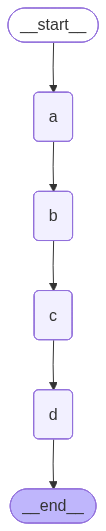

In [3]:
# ============================================================================
# IMPORTS
# ============================================================================
from IPython.display import Image, display
from typing import Any
from typing_extensions import TypedDict
from typing import Annotated
import operator
from langgraph.graph import StateGraph, START, END

# ============================================================================
# STEP 1: DEFINE THE STATE SCHEMA
# ============================================================================
# The State class defines the structure of data that flows through our graph.
# Think of it as the "memory" or "context" that each node can read and write to.

class State(TypedDict):
    """
    State schema for our workflow.
    
    The `Annotated[list, operator.add]` syntax is crucial:
    - `list` is the data type
    - `operator.add` is the REDUCER function that defines HOW updates are merged
    
    When operator.add is applied to lists, it performs LIST CONCATENATION.
    This means: [1, 2] + [3] = [1, 2, 3]
    
    Without a reducer, the last update would OVERWRITE previous values!
    """
    state: Annotated[list, operator.add]

# ============================================================================
# STEP 2: DEFINE NODE LOGIC (Using a Callable Class)
# ============================================================================
# Nodes can be defined as functions OR callable classes.
# Using a class allows us to store configuration (like node_secret) during initialization.

class ReturnNodeValue:
    """
    A callable class that represents a graph node.
    
    When LangGraph executes this node, it calls the __call__ method.
    Each instance stores a unique identifier (node_secret) to track execution order.
    """
    
    def __init__(self, node_secret: str):
        """Store the node's identifier during initialization."""
        self._value = node_secret

    def __call__(self, state: State) -> Any:
        """
        This method is called when the node executes.
        
        Args:
            state: The current graph state (passed automatically by LangGraph)
            
        Returns:
            A dictionary with state updates. Keys match State fields.
            The value [self._value] is wrapped in a list because our reducer
            uses operator.add (list concatenation).
        """
        print(f"Adding {self._value} to {state['state']}")
        return {"state": [self._value]}

# ============================================================================
# STEP 3: BUILD THE GRAPH
# ============================================================================
# StateGraph is the main class for constructing LangGraph workflows.
# We pass the State class so the graph knows our state schema.

builder = StateGraph(State)

# ============================================================================
# STEP 4: ADD NODES TO THE GRAPH
# ============================================================================
# Each node has a unique name (string) and a callable (function or class instance).
# The names "a", "b", "c", "d" are used to reference nodes when adding edges.

builder.add_node("a", ReturnNodeValue("step A"))
builder.add_node("b", ReturnNodeValue("step B"))
builder.add_node("c", ReturnNodeValue("step C"))
builder.add_node("d", ReturnNodeValue("step D"))

# ============================================================================
# STEP 5: DEFINE THE FLOW (EDGES)
# ============================================================================
# Edges define the execution order. In a linear workflow, each node leads to exactly one other node.
# START and END are special constants representing entry and exit points.

builder.add_edge(START, "a")  # Entry point: START → a
builder.add_edge("a", "b")    # Sequential: a → b
builder.add_edge("b", "c")    # Sequential: b → c
builder.add_edge("c", "d")    # Sequential: c → d
builder.add_edge("d", END)    # Exit point: d → END

# ============================================================================
# STEP 6: COMPILE THE GRAPH
# ============================================================================
# compile() validates the graph structure and creates an executable workflow.
# After compilation, the graph is ready to process inputs.

graph = builder.compile()

# ============================================================================
# VISUALIZE THE GRAPH
# ============================================================================
# LangGraph can generate visual representations using Mermaid diagrams.
# This helps understand the flow structure at a glance.

display(Image(graph.get_graph().draw_mermaid_png()))

### Execute the Linear Workflow

Let's run the graph and observe the execution order. Notice how:
1. Each step executes sequentially (A → B → C → D)
2. The state list grows with each step due to the `operator.add` reducer
3. The final state contains all steps in order: `["step A", "step B", "step C", "step D"]`

In [4]:
# Invoke the graph with an empty initial state
# The graph.invoke() method:
#   - Takes initial state as input
#   - Executes all nodes according to the defined edges
#   - Returns the final state after all nodes have executed

result = graph.invoke({"state": []})

print("\n" + "="*50)
print("FINAL STATE:")
print("="*50)
print(f"Execution order: {result['state']}")

Adding step A to []
Adding step B to ['step A']
Adding step C to ['step A', 'step B']
Adding step D to ['step A', 'step B', 'step C']

FINAL STATE:
Execution order: ['step A', 'step B', 'step C', 'step D']


---

## Part 2: Parallel Workflow with Fan-Out and Fan-In

Now let's introduce **parallel execution**! Instead of running all steps sequentially, we'll run some steps concurrently:

```
        ┌──→ B ──┐
START → A       ├──→ D → END
        └──→ C ──┘
```

### Key Concepts

| Concept | Description | Real-World Analogy |
|---------|-------------|-------------------|
| **Fan-Out** | One node branches to multiple nodes for simultaneous execution | Like a manager delegating tasks to multiple team members |
| **Fan-In** | Multiple nodes converge back to a single node | Like collecting results from all team members before moving forward |

### Why Use Parallel Execution?

1. **Performance**: Tasks B and C run simultaneously, reducing total execution time
2. **Independence**: B and C don't depend on each other's results
3. **Aggregation**: Node D receives combined results from both B and C

### Critical: Reducers in Parallel Workflows

When multiple nodes write to the **same state key** simultaneously, you MUST use a reducer to define how updates are combined:

```python
# Without reducer: Last write wins (data loss!)
state: list  # ❌ Dangerous in parallel workflows

# With reducer: Updates are merged correctly
state: Annotated[list, operator.add]  # ✅ Safe - lists are concatenated
```

> **Remember**: `operator.add` on lists performs concatenation: `[B] + [C] = [B, C]`

PARALLEL WORKFLOW VISUALIZATION:
Notice how 'b' and 'c' branch from 'a' and converge at 'd'


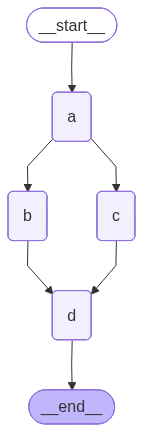

In [5]:
# ============================================================================
# PARALLEL EXECUTION WITH FAN-OUT AND FAN-IN
# ============================================================================
import operator
from typing import Annotated

# State schema with reducer (same as before - essential for parallel writes)
class State(TypedDict):
    """
    State with operator.add reducer.
    This is CRITICAL for parallel execution - without it, 
    concurrent writes would overwrite each other!
    """
    state: Annotated[list, operator.add]

# ============================================================================
# BUILD THE PARALLEL GRAPH
# ============================================================================
builder = StateGraph(State)

# Add the same nodes as before
builder.add_node("a", ReturnNodeValue("step A"))
builder.add_node("b", ReturnNodeValue("step B"))
builder.add_node("c", ReturnNodeValue("step C"))
builder.add_node("d", ReturnNodeValue("step D"))

# ============================================================================
# DEFINE PARALLEL FLOW
# ============================================================================
# The key difference from linear workflow is in how we define edges:

# Entry point (same as linear)
builder.add_edge(START, "a")

# FAN-OUT: Node 'a' has TWO outgoing edges!
# This tells LangGraph to execute 'b' and 'c' IN PARALLEL
builder.add_edge("a", "b")  # a → b (parallel branch 1) 
builder.add_edge("a", "c")  # a → c (parallel branch 2)

# FAN-IN: Both 'b' and 'c' point to 'd'
# LangGraph will WAIT for BOTH to complete before running 'd'
builder.add_edge("b", "d")  # b → d (converge from branch 1)
builder.add_edge("c", "d")  # c → d (converge from branch 2)

# Exit point
builder.add_edge("d", END)

# Compile and visualize
graph = builder.compile()

print("PARALLEL WORKFLOW VISUALIZATION:")
print("Notice how 'b' and 'c' branch from 'a' and converge at 'd'")
display(Image(graph.get_graph().draw_mermaid_png()))

In [6]:
# ============================================================================
# EXECUTE THE PARALLEL WORKFLOW
# ============================================================================
# Run the graph and observe:
# 1. Node 'a' executes first
# 2. Nodes 'b' and 'c' execute IN PARALLEL (order may vary!)
# 3. Node 'd' executes after BOTH 'b' and 'c' complete
# 4. The reducer combines outputs from parallel nodes

result = graph.invoke({"state": []})

print("\n" + "="*50)
print("FINAL STATE:")
print("="*50)
print(f"Execution order: {result['state']}")
print("\nNote: 'step B' and 'step C' ran in parallel - their order may vary!")

Adding step A to []
Adding step B to ['step A']
Adding step C to ['step A']
Adding step D to ['step A', 'step B', 'step C']

FINAL STATE:
Execution order: ['step A', 'step B', 'step C', 'step D']

Note: 'step B' and 'step C' ran in parallel - their order may vary!


### Understanding the Output

Observe the execution:
- Node `b` and `c` both ran and appended their values to the state
- Thanks to the `operator.add` reducer, both values are preserved (not overwritten)
- The final state contains: `["step A", "step B", "step C", "step D"]`

> **Key Insight**: Without the reducer, whichever node finished last would overwrite the other's value, causing data loss!

---

## Part 3: Asymmetric Parallel Paths

In real-world scenarios, parallel paths often have **different lengths**. For example:
- One path might involve a simple lookup
- Another path might require multiple processing steps

```
        ┌──→ B → X ──┐
START → A            ├──→ D → END
        └──→ C ──────┘
```

### The Challenge

When paths have different lengths, LangGraph needs to know when to proceed to the next node. 

### The Solution: List-Based Fan-In

Instead of adding separate edges, we use a **list syntax** to specify multiple source nodes:

```python
builder.add_edge(["x", "c"], "d")  # Wait for BOTH x AND c before running d
```

This explicitly tells LangGraph: "Don't run node `d` until both `x` and `c` have completed."

ASYMMETRIC PARALLEL PATHS:
Notice: Path A→B→X is longer than Path A→C
Node 'd' waits for BOTH paths to complete


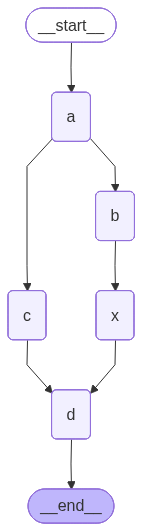

In [7]:
# ============================================================================
# ASYMMETRIC PARALLEL PATHS
# ============================================================================
# This example demonstrates handling parallel paths of DIFFERENT LENGTHS:
#   - Path 1: A → B → X (2 nodes after A)
#   - Path 2: A → C     (1 node after A)
# Both paths must complete before D can execute.

builder = StateGraph(State)

# ============================================================================
# ADD NODES
# ============================================================================
# Notice we now have 5 nodes: A, B, X, C, D
# Path 1 has an extra step (X) compared to Path 2

builder.add_node("a", ReturnNodeValue("step A"))  # Entry point
builder.add_node("b", ReturnNodeValue("step B"))  # Path 1, step 1
builder.add_node("x", ReturnNodeValue("step X"))  # Path 1, step 2 (extra step)
builder.add_node("c", ReturnNodeValue("step C"))  # Path 2, step 1
builder.add_node("d", ReturnNodeValue("step D"))  # Convergence point

# ============================================================================
# DEFINE ASYMMETRIC FLOW
# ============================================================================

# Entry point
builder.add_edge(START, "a")

# FAN-OUT: Split into two parallel paths
builder.add_edge("a", "b")  # Path 1 starts
builder.add_edge("a", "c")  # Path 2 starts

# Path 1 continues with an extra step
builder.add_edge("b", "x")  # B → X (Path 1 is longer)

# FAN-IN WITH LIST SYNTAX: Wait for BOTH paths to complete
# This is the KEY difference - using a list to specify multiple source nodes
# LangGraph will wait for BOTH "x" AND "c" before running "d"
builder.add_edge(["x", "c"], "d")  # Explicit synchronization point

# Exit point
builder.add_edge("d", END)

# Compile and visualize
graph = builder.compile()

print("ASYMMETRIC PARALLEL PATHS:")
print("Notice: Path A→B→X is longer than Path A→C")
print("Node 'd' waits for BOTH paths to complete")
display(Image(graph.get_graph().draw_mermaid_png()))

### Execution Behavior

In this configuration:
- Nodes `b` and `c` run in parallel after `a` completes
- Node `x` runs after `b` completes (sequential within Path 1)
- Node `d` **waits for both** `x` AND `c` to complete before running

This pattern is useful when:
- Different data sources require different processing pipelines
- Some paths involve more complex transformations than others
- You need to synchronize results from paths of varying complexity

In [8]:
# ============================================================================
# EXECUTE THE ASYMMETRIC WORKFLOW
# ============================================================================
# Watch the execution order carefully:
# 1. 'a' runs first
# 2. 'b' and 'c' start in parallel
# 3. 'x' runs after 'b' completes (but 'c' may still be running or already done)
# 4. 'd' runs only after BOTH 'x' AND 'c' complete

result = graph.invoke({"state": []})

print("\n" + "="*50)
print("FINAL STATE:")
print("="*50)
print(f"Execution sequence: {result['state']}")
print("\nNote: C may appear before or after B/X depending on execution timing")

Adding step A to []
Adding step B to ['step A']
Adding step C to ['step A']
Adding step X to ['step A', 'step B', 'step C']
Adding step D to ['step A', 'step B', 'step C', 'step X']

FINAL STATE:
Execution sequence: ['step A', 'step B', 'step C', 'step X', 'step D']

Note: C may appear before or after B/X depending on execution timing


---

## Part 4: Real-World Example - Parallel Search with LLM Synthesis

Now let's apply what we've learned to a **practical use case**! We'll build an agent that:

1. **Searches Wikipedia** and **Web** in parallel (fan-out)
2. **Combines the results** from both sources (reducer)
3. **Generates an answer** using an LLM (fan-in)

```
            ┌──→ Wikipedia Search ──┐
START ──────┤                       ├──→ Generate Answer → END
            └──→ Web Search ────────┘
```

### Why This Pattern is Powerful

| Without Parallelization | With Parallelization |
|------------------------|---------------------|
| Wikipedia Search: 2s | Wikipedia Search: 2s |
| Web Search: 3s | Web Search: 3s (runs simultaneously) |
| **Total: 5s** | **Total: 3s** (40% faster!) |

### Architecture Overview

![](https://i.imgur.com/t44twOn.png)

### Step 1: Initialize the LLM

We'll use OpenAI's GPT-4o-mini model for generating the final answer.

In [9]:
# ============================================================================
# SETUP: Import LLM Helper Functions
# ============================================================================
# We use helper functions to create LLM instances with proper configuration
# These functions handle API key loading and model configuration

import os
import sys

# Add parent directory to path for importing helpers
sys.path.append(os.path.abspath("../.."))

# Import our LLM factory functions
# - get_groq_llm(): Creates a Groq-hosted LLM (fast inference)
# - get_openai_llm(): Creates an OpenAI GPT model
from helpers.utils import get_groq_llm, get_openai_llm,get_databricks_llm

print("LLM helpers imported successfully!")

# ============================================================================
# CREATE THE LLM AND CHATBOT GRAPH
# ============================================================================

# -----------------------------------------------------------------------------
# Step 1: Initialize the LLM
# We use Groq for fast inference, but you can swap to OpenAI
# -----------------------------------------------------------------------------
llm = get_databricks_llm("databricks-claude-sonnet-4")  # Fast, open-source models hosted by Groq
# Alternative: llm = get_openai_llm()  # OpenAI's GPT models

if hasattr(llm, 'model_name'):
    print(f"LLM initialized: {llm.model_name}")
elif hasattr(llm, 'model'):
    print(f"LLM initialized: {llm.model} (Databricks)")
else:
    print("LLM initialized: Groq LLM")

LLM helpers imported successfully!
LLM initialized: databricks-claude-sonnet-4 (Databricks)


### Step 2: Define the State Schema

The state schema defines what data flows through our agent. Notice:
- `question`: The user's input question (single value)
- `answer`: The LLM's response (single value)
- `context`: Accumulated search results (uses `operator.add` reducer for parallel writes!)

In [10]:
# ============================================================================
# STATE SCHEMA FOR PARALLEL SEARCH AGENT
# ============================================================================

class State(TypedDict):
    """
    State schema for the parallel search agent.
    
    Fields:
    - question: The user's input question (read by search nodes)
    - answer: The LLM's final response (written by generate_answer node)
    - context: Search results from multiple sources (CRITICAL: uses reducer!)
    
    Why operator.add on context?
    ----------------------------
    Both search_web and search_wikipedia run IN PARALLEL and write to 'context'.
    Without the reducer, one would overwrite the other!
    With operator.add, their results are CONCATENATED:
        context from web + context from wikipedia = combined context
    """
    question: str                            # Input: User's question
    answer: str                              # Output: LLM's answer
    context: Annotated[list, operator.add]   # Accumulated search results

### Step 3: Define Node Functions and Build the Agent Graph

Now we define three node functions:

1. **`search_web`**: Searches the web using Tavily API (runs in parallel)
2. **`search_wikipedia`**: Searches Wikipedia (runs in parallel)  
3. **`generate_answer`**: Uses LLM to synthesize an answer from combined context

Each function:
- Receives the current `state` as input
- Returns a dictionary with state updates
- For search nodes, wraps results in a list `[result]` to work with the `operator.add` reducer

PARALLEL SEARCH AGENT ARCHITECTURE:
Both search nodes run simultaneously, then combine results for the LLM


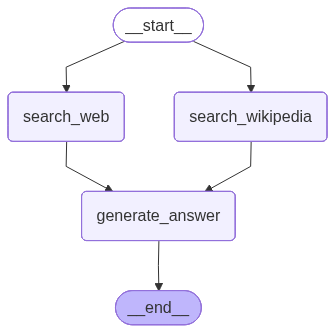

In [11]:
# ============================================================================
# IMPORTS
# ============================================================================
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_community.document_loaders import WikipediaLoader
from langchain_community.tools import TavilySearchResults

# ============================================================================
# NODE FUNCTION 1: WEB SEARCH (Parallel Branch 1)
# ============================================================================
def search_web(state):
    """
    Search the web using Tavily API.
    
    This node runs IN PARALLEL with search_wikipedia.
    
    Args:
        state: Current graph state containing the user's question
        
    Returns:
        Dict with context update. Note the [formatted_search_docs] - 
        wrapped in a list to work with the operator.add reducer!
    """
    print('--Getting Info from the Web--')

    # Initialize Tavily search tool (retrieves top 3 results)
    tavily_search = TavilySearchResults(max_results=3)
    
    # Perform the search using the user's question
    search_docs = tavily_search.invoke(state['question'])

    # Format results into a readable string with source URLs
    # This helps the LLM understand where information came from
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'''Content: {doc['content']}\nSource: {doc['url']}'''
            for doc in search_docs
        ]
    )

    # IMPORTANT: Return as [list] to work with operator.add reducer
    # This allows parallel results to be concatenated, not overwritten
    return {"context": [formatted_search_docs]}


# ============================================================================
# NODE FUNCTION 2: WIKIPEDIA SEARCH (Parallel Branch 2)
# ============================================================================
def search_wikipedia(state):
    """
    Search Wikipedia for relevant articles.
    
    This node runs IN PARALLEL with search_web.
    
    Args:
        state: Current graph state containing the user's question
        
    Returns:
        Dict with context update wrapped in a list for the reducer
    """
    print('--Getting Info from the Wikipedia--')

    # Load up to 2 Wikipedia articles matching the query
    search_docs = WikipediaLoader(
        query=state['question'],
        load_max_docs=2
    ).load()

    # Format results with content and source
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'''Content: {doc.page_content}\nSource: {doc.metadata["source"]}'''
            for doc in search_docs
        ]
    )

    # Return as list for reducer compatibility
    return {"context": [formatted_search_docs]}


# ============================================================================
# NODE FUNCTION 3: ANSWER GENERATION (Fan-In Point)
# ============================================================================
def generate_answer(state):
    """
    Generate a final answer using the LLM.
    
    This node runs AFTER both search nodes complete (fan-in).
    It receives the COMBINED context from both Wikipedia and Web searches.
    
    Args:
        state: Graph state with accumulated context from parallel searches
        
    Returns:
        Dict with the LLM's answer
    """
    print('--Generating final answer--')

    # Extract accumulated context and original question from state
    # Note: context is a LIST of search results (thanks to our reducer)
    context = state["context"]
    question = state["question"]

    # Create a prompt template for the LLM
    # The LLM will use BOTH web and Wikipedia results to answer
    answer_template = """Answer the question {question}
                         using these context documents: {context}"""
    
    answer_instructions = answer_template.format(
        question=question,
        context=context  # Contains results from BOTH searches
    )

    # Invoke the LLM with system instructions and a human message
    answer = llm.invoke([
        SystemMessage(content=answer_instructions),
        HumanMessage(content="Answer the question.")
    ])

    # Return the answer (no need for list here - only one node writes to 'answer')
    return {"answer": answer}


# ============================================================================
# BUILD THE PARALLEL SEARCH AGENT GRAPH
# ============================================================================
builder = StateGraph(State)

# Add all three nodes to the graph
builder.add_node("search_web", search_web)
builder.add_node("search_wikipedia", search_wikipedia)
builder.add_node("generate_answer", generate_answer)

# ============================================================================
# DEFINE PARALLEL FLOW
# ============================================================================

# FAN-OUT: Both searches start immediately from START
# Notice: START has TWO outgoing edges - this triggers parallel execution!
builder.add_edge(START, "search_wikipedia")  # Branch 1: Wikipedia
builder.add_edge(START, "search_web")        # Branch 2: Web (runs in parallel!)

# FAN-IN: Both searches converge at generate_answer
# LangGraph waits for BOTH to complete before running generate_answer
builder.add_edge("search_wikipedia", "generate_answer")
builder.add_edge("search_web", "generate_answer")

# Final step: Answer generation leads to END
builder.add_edge("generate_answer", END)

# Compile the graph
graph = builder.compile()

# ============================================================================
# VISUALIZE THE AGENT
# ============================================================================
print("PARALLEL SEARCH AGENT ARCHITECTURE:")
print("Both search nodes run simultaneously, then combine results for the LLM")
display(Image(graph.get_graph().draw_mermaid_png()))

### Step 4: Test the Parallel Search Agent

Let's test our agent with a real question! Watch the output to see:
1. Both search functions start (nearly) simultaneously
2. Results are combined before answer generation
3. The LLM synthesizes information from BOTH sources

In [14]:
# ============================================================================
# INVOKE THE PARALLEL SEARCH AGENT
# ============================================================================
# Ask a question that benefits from multiple sources:
# - Wikipedia: Provides foundational/historical information
# - Web Search: Provides recent news and current information

question = "Tell me about Nvidia and its growth"

print(f"Question: {question}")
print("="*50)
print()

# Execute the agent
# The graph will:
# 1. Run search_web AND search_wikipedia IN PARALLEL
# 2. Wait for both to complete
# 3. Pass combined context to generate_answer
# 4. Return the final state

result = graph.invoke({"question": question})

print()
print("="*50)
print("Agent execution complete!")

Question: Tell me about Nvidia and its growth

--Getting Info from the Web--
--Getting Info from the Wikipedia--
--Generating final answer--

Agent execution complete!


In [15]:
# ============================================================================
# DISPLAY THE FINAL ANSWER
# ============================================================================
# The answer is generated by the LLM using context from BOTH:
# - Wikipedia articles (foundational knowledge)
# - Web search results (recent information)

print("="*60)
print("AGENT'S ANSWER")
print("="*60)
print()
print(result['answer'].content)

# Optional: Inspect the combined context that was passed to the LLM
print()
print("="*60)
print("SOURCES USED (Context)")
print("="*60)
print(f"Number of context chunks: {len(result['context'])}")
for i, ctx in enumerate(result['context']):
    print(f"\n--- Source {i+1} ---")
    print(ctx[:500] + "..." if len(ctx) > 500 else ctx)

AGENT'S ANSWER

Based on the provided documents, here's an overview of Nvidia and its remarkable growth:

## About Nvidia

Nvidia was founded in 1993 by Jensen Huang (who remains CEO today) as a graphics processing company. The company started from humble beginnings - literally launched from a Denny's restaurant when Huang was 30 years old. Nvidia has since transformed from a niche graphics card maker into the world's largest company by market capitalization.

## Key Growth Milestones

**Early Years (1990s-2000s):**
- 1999: Went public at $12/share and released the GeForce 256, the industry's first GPU
- 2000: Became graphics supplier for Microsoft's Xbox
- 2001: Revenue exceeded $1 billion; added to Nasdaq 100 and S&P 500
- 2006: Released CUDA, enabling GPUs for general-purpose computing beyond graphics

**Strategic Expansion:**
- Diversified beyond gaming into automotive (Audi partnership), aerospace (NASA Mars simulation), and mobile computing
- 2007: Named Forbes "Company of the Ye

## Summary: Key Takeaways

### What We Learned

1. **Parallel Execution Basics**
   - LangGraph supports concurrent node execution through fan-out/fan-in patterns
   - Multiple edges from one node trigger parallel execution of target nodes

2. **Fan-Out Pattern**
   - A single node with multiple outgoing edges → parallel execution
   - Example: `START → [search_web, search_wikipedia]`

3. **Fan-In Pattern**  
   - Multiple nodes pointing to one node → synchronization point
   - LangGraph waits for ALL source nodes to complete before proceeding

4. **Reducers are Critical**
   - Use `Annotated[type, reducer]` when parallel nodes write to the same key
   - `operator.add` concatenates lists; without it, last-write-wins causes data loss

5. **Asymmetric Paths**
   - Use list syntax for explicit synchronization: `builder.add_edge(["x", "c"], "d")`
   - Handles paths of different lengths gracefully

### Common Patterns

| Pattern | Use Case | Implementation |
|---------|----------|----------------|
| Parallel Search | Multiple data sources | Fan-out at START, fan-in before synthesis |
| Map-Reduce | Process items in parallel | Fan-out to workers, fan-in to aggregator |
| Parallel Validation | Multiple checks | Fan-out to validators, fan-in to decision node |

### Next Steps

- Explore **conditional edges** for dynamic parallel paths
- Learn about **subgraphs** for nested parallel workflows
- Implement **error handling** in parallel execution